## Load Library

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from Cython.Compiler.Naming import args_cname
from tensorboard.compat.tensorflow_stub.dtypes import float32
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torch.optim as optim
import os
from torch.optim.lr_scheduler import MultiStepLR
import gc

In [4]:
os.chdir('/content/drive/MyDrive')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

In [6]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []

    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            mean = torch.tensor(0.1307, dtype=torch.float32).view(1, 1, 1)
            std  = torch.tensor(0.3081, dtype=torch.float32).view(1, 1, 1)
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)


In [7]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [8]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)

Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


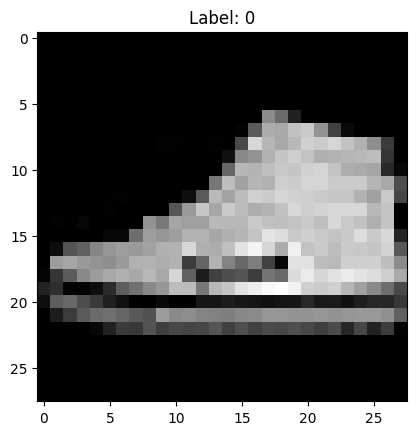

In [9]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

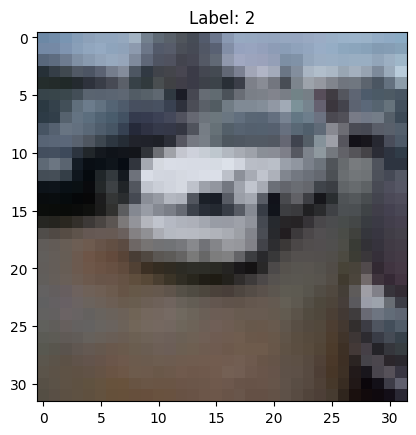

In [10]:
# CIFAR data checking
mean_test = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
std_test  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
test_cifar = Xtr_cifar[514] * std_test + mean_test
plt.imshow(np.transpose(test_cifar, (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

In [146]:
class FixedTransition(nn.Module):
    def __init__(self, T: torch.Tensor):
        super().__init__()
        # 确保是 float32 且在正确 device
        T = T.detach().float()
        self.register_buffer("T", T)  # 不会被 optimizer 更新

    def forward(self):
        return self.T
def select_known_T(dataset_name: str):
    # 你的常量真 T（注意命名与设备）
    mnist03_T = torch.tensor([
        [0.7, 0.3, 0.0],
        [0.0, 0.7, 0.3],
        [0.3, 0.0, 0.7]
    ], dtype=torch.float32, device=device)

    mnist06_T = torch.tensor([
        [0.4, 0.3, 0.3],
        [0.3, 0.4, 0.3],
        [0.3, 0.3, 0.4]
    ], dtype=torch.float32, device=device)

    name = dataset_name.lower()
    if "3" in name or "mnist03" in name:
        return FixedTransition(mnist03_T)
    if "6" in name or "mnist06" in name:
        return FixedTransition(mnist06_T)
    return None  # 第三个数据集：未知 T

# Main Program

## Classifier: ResNet-tiny

In [176]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'cifar':
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

def ResNet_tiny(num_classes,mode):
  return ResNet(BasicBlock, [1,1,1], num_classes,mode)

## Transition matrix initialization

In [177]:

class sig_t(nn.Module):
    def __init__(self, device, num_classes, init=2):
        super(sig_t, self).__init__()

        C = num_classes
        self.register_parameter(name='w', param=nn.parameter.Parameter(-init*torch.ones(num_classes, num_classes)))

        #self.w.to(device)

        co = torch.full((C, C), 0.3, device=device)
        co.fill_diagonal_(0.4)
        self.register_buffer("co", co)                    # [ADD] 用 buffer 存常量
        self.register_buffer("I", torch.eye(C))
        #self.co = co.to(device)
        #self.identity = torch.eye(num_classes).to(device)


    def forward(self):
        sig = torch.sigmoid(self.w)
        #T = self.identity.detach() + sig * self.co.detach()
        #T = F.normalize(T, p=1, dim=1)
        T = self.I + sig * self.co
        return T


def row_stoch(M, eps=1e-8):
    M = M.clamp_min(eps)
    return M / (M.sum(dim=1, keepdim=True) + eps)


## Main structrue

In [178]:
def warmup(train_data, train_loader, model,optimizer_model, loss_func_ce):

    model.train()
    train_loss = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_model.zero_grad()

        clean = model(batch_x)

        ce_loss = loss_func_ce(clean.log(), batch_y.long())
        #res = torch.mean(torch.sum(clean.log() * clean, dim=1))
        loss = ce_loss #+ res

        train_loss += loss.item()

        loss.backward()
        optimizer_model.step()


    print('Warmup Loss: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size))


def train(train_data, train_loader,model,trans_for,trans_back,optimizer_es,optimizer_trans_for,optimizer_trans_back,scheduler1,scheduler2,scheduler3,loss_func_ce):
    model.train()
    trans_back.train()
    trans_for.train()

    if optimizer_trans_for is None:
        trans_for.eval()
    else:
        trans_for.train()

    eps = 1e-8
    w_cycle = 0.3

    loss_sum = 0.0
    acc_sum  = 0
    n_samp   = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y_idx = batch_y.to(device).long()

        clean = model(batch_x)
        noisy_1h = torch.zeros(batch_x.size(0), Cfg.num_classes, device=device).scatter_(1, batch_y_idx.view(-1,1), 1)

        # === forward 矩阵 ===
        T_for = trans_for()
        T_back = trans_back()

        T_for  = row_stoch(T_for)
        T_back = row_stoch(T_back)

        p_noisy_pred = (clean @ T_for).clamp_min(eps)            # [B,C]
        L1 = loss_func_ce(p_noisy_pred.log(), batch_y_idx)       # CE(T f(x), y_tilde)

        # ------- L2: backward（clean 空间，soft 目标） -------
        p_clean_from_noisy = (noisy_1h @ T_back).clamp_min(eps)  # [B,C]
        L2 = -(p_clean_from_noisy * clean.clamp_min(eps).log()).sum(dim=1).mean()

        # ------- L3: cycle-consistency（只对 w 求导） -------
        T_for_det  = T_for.detach()
        T_back_det = T_back.detach()
        p_cycle = ((clean @ T_for_det).clamp_min(eps) @ T_back_det).clamp_min(eps)
        L3 = -(clean * p_cycle.log()).sum(dim=1).mean()

        #I = torch.eye(Cfg.num_classes, device=device, dtype=torch.float32)
        #R_inv = F.mse_loss(torch.mm(T_back, T_for), I) + F.mse_loss(torch.mm(T_for, T_back), I)

        loss = L1 + L2 + w_cycle * L3

        pred_noisy = p_noisy_pred.argmax(dim=1)
        acc_sum += (pred_noisy == batch_y_idx).sum().item()


        optimizer_es.zero_grad()
        if optimizer_trans_for is not None:
            optimizer_trans_for.zero_grad()
        optimizer_trans_back.zero_grad()

        loss.backward()

        optimizer_es.step()
        if optimizer_trans_for is not None:
            optimizer_trans_for.step()
        optimizer_trans_back.step()

        bs = batch_x.size(0)
        loss_sum += loss.item() * bs
        n_samp += bs

    print('Train Loss: {:.6f},  Acc: {:.6f}'.format(loss_sum / max(1, n_samp), acc_sum / max(1, n_samp)))  # [FIX]

    scheduler1.step()
    if scheduler2 is not None:
        scheduler2.step()
    scheduler3.step()


def val(val_data, val_loader, model, trans, loss_func_ce):
    val_correct = 0
    val_loss_sum = 0.0
    total_n = 0
    with torch.no_grad():
        model.eval()
        trans.eval()

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            clean = model(batch_x)                 # [B,C] 概率
            T_back = trans()
            T_back = row_stoch(T_back)
            T_back = T_back / (T_back.sum(dim=0, keepdim=True) + 1e-8)  # [FIX] 列随机

            # noisy one-hot
            noisy_1h = torch.zeros(batch_x.size(0), Cfg.num_classes, device=device).scatter_(1, batch_y.view(-1,1), 1)

            # 估计 clean 标签（noisy -> t_back -> clean）
            est_clean = torch.mm(noisy_1h, T_back).clamp_min(1e-8)
            est_clean_y = est_clean.argmax(dim=1)

            # loss（注意：NLLLoss，log 前 clamp）
            loss = -(est_clean * clean.clamp_min(1e-8).log()).sum(dim=1).mean()

            pred_clean = clean.argmax(dim=1)
            est_clean_y = est_clean.argmax(dim=1)
            bs = batch_x.size(0)
            val_correct += (pred_clean == est_clean_y).sum().item()
            val_loss_sum += loss.item() * bs
            total_n += bs

    avg_val_loss = val_loss_sum / max(1, total_n)
    avg_val_acc  = val_correct / max(1, total_n)
    print('Val Loss: {:.6f}, Acc: {:.6f}'.format(avg_val_loss, avg_val_acc))
    return avg_val_loss


def test(test_data, test_loader, model, loss_func_ce):
    eval_loss = 0.
    eval_acc = 0.

    with torch.no_grad():
        model.eval()

        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)

            loss = loss_func_ce(clean.clamp_min(1e-8).log(), batch_y.long())
            eval_loss += loss.item()
            pred = torch.max(clean, 1)[1]
            eval_correct = (pred == batch_y).sum()
            eval_acc += eval_correct.item()

        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)) * Cfg.batch_size,
                                                      eval_acc / (len(test_data))))
    return eval_acc / (len(test_data))


## Operation process

In [179]:
def main(dataset_name):

      try:
          del model
      except:
          pass
      try:
          del trans; del trans_1
      except:
          pass
      gc.collect()
      if torch.cuda.is_available():
        torch.cuda.empty_cache()

      #init
      criterion = torch.nn.NLLLoss(reduction="mean")
      model = ResNet_tiny(Cfg.num_classes, dataset_name)
      milestones = Cfg.milestones

      if dataset_name.lower() in ("mnist03"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.3.npz"))
      elif dataset_name.lower() in ("mnist06"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.6.npz"))
      elif dataset_name.lower() in ("cifar"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_cifar(*load_dataset("datasets/CIFAR.npz"))
      else:
          raise ValueError(f"Unsupported dataset: {dataset_name}")

      train_data = TensorDataset(Xtr, ytr)
      val_data = TensorDataset(Xva, yva)
      test_data = TensorDataset(Xte, yte)

      trans_known = select_known_T(dataset_name)                 # [MOD] FixedTransition(...) 或 None
      has_clean_T = trans_known is not None                      # [MOD]

          # === 初始化 transition 矩阵 ===
      if has_clean_T:                                            # [MOD]
          print(f"[Info] Using provided true transition matrix for {dataset_name}")  # [MOD]
          trans = trans_known                                    # [MOD] forward：直接用固定模块（可 .eval()/.train()）
          optimizer_trans = None                                  # [MOD] 有真 T 不需要优化器
          scheduler2 = None                                       # [MOD]
      else:
          trans = sig_t(device, Cfg.num_classes)                  # 原逻辑：forward 学习的 sig_t
          optimizer_trans = optim.AdamW(trans.parameters(), lr=Cfg.lr, weight_decay=0)
          scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)


      trans_1 = sig_t(device, Cfg.num_classes)
      #optimizer_trans = optim.AdamW(trans.parameters(), lr=Cfg.lr, weight_decay=0)
      optimizer_trans_1 = optim.AdamW(trans_1.parameters(), lr=Cfg.lr, weight_decay=0)


      #optimizer and StepLR
      optimizer_es = optim.AdamW(model.parameters(), lr=Cfg.lr, weight_decay=Cfg.weight_decay)
      scheduler1 = MultiStepLR(optimizer_es, milestones=milestones, gamma=0.1)
      #scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)
      scheduler3 = MultiStepLR(optimizer_trans_1, milestones=milestones, gamma=0.1)


      #data_loader
      train_loader = DataLoader(dataset=train_data,
                                batch_size=Cfg.batch_size,
                                shuffle=True,
                                num_workers=4,
                                drop_last=False)

      val_loader = DataLoader(dataset=val_data,
                              batch_size=Cfg.batch_size,
                              shuffle=False,
                              num_workers=4,
                              drop_last=False)

      test_loader = DataLoader(dataset=test_data,
                              batch_size=Cfg.batch_size,
                              num_workers=4,
                              drop_last=False)

      #cuda
      if torch.cuda.is_available():
          model = model.to(device)
          trans = trans.to(device)
          trans_1 = trans_1.to(device)


      best_acc = 0
      best_acc_back = 0
      #warmup
      for epoch in range(Cfg.warmup_epoch):
          print('epoch[{}], Warmup'.format(epoch + 1))
          warmup(train_data, train_loader, model,optimizer_es, criterion)
          val(val_data, val_loader, model, trans_1, criterion)
          acc = test(test_data, test_loader, model,criterion)
          if acc> best_acc:
              best_acc = acc
          print('Best_acc: {:.6f}'.format(best_acc))

      acc_list = []
      loss_list = []
      early_stop = 0
      best_val_loss = float('inf')

      #train
      for epoch in range(Cfg.n_epoch):
          print('epoch[{}], Train'.format(epoch+1))
          train(train_data,train_loader,model,trans,trans_1,optimizer_es,optimizer_trans,optimizer_trans_1,scheduler1,scheduler2,scheduler3,criterion)
          val_loss = val(val_data, val_loader, model, trans_1,criterion)
          acc = test(test_data, test_loader, model,criterion)

          acc_list.append(acc)
          loss_list.append(val_loss)

          improved = val_loss < best_val_loss - 1e-6
          best_acc = max(best_acc, acc)

          if improved:                                  # [MOD] 变号：更小的 loss 更好
            best_val_loss = val_loss                  # [MOD]

            early_stop = 0                            # [MOD]
            print('Best_acc: {:.6f}'.format(best_acc))
          else:
            early_stop += 1
            print('Best_acc: {:.6f}'.format(best_acc))
            if early_stop >= Cfg.es_epoch:            # [MOD]
              print(f"⏹ Early stopping at epoch {epoch+1} (best val_loss={best_val_loss:.6f}, best acc={best_acc:.6f})")
              break

      with torch.no_grad():
        Tf_np = trans().detach().cpu().numpy()
        Tb_np = trans_1().detach().cpu().numpy()

      print('Best_acc: ', best_acc)
      return best_acc,acc_list,loss_list,Tf_np, Tb_np


# Running

In [180]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Cfg:
    num_classes: int = 3
    dataset: str = "mnist06"
    batch_size: int = 128
    lr: float = 0.005
    weight_decay: float = 1e-5
    milestones: Tuple[int, int] = (30, 60)
    lam: float = 0.6                 # weight for cycle term
    n_epoch: int = 120
    warmup_epoch: int = 5
    es_epoch: int = 60
    anchor: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    lambda_T: float = 0.05
    beta_fc: float = 1.0

In [ ]:
best,acc_list,loss_list ,Tf, Tb = main(Cfg.dataset)

epoch[1], Warmup
Warmup Loss: 1.132180
Val Loss: 1.121845, Acc: 0.357333
Test Loss: 1.111121, Acc: 0.448000
Best_acc: 0.448000
epoch[2], Warmup
Warmup Loss: 1.104111
Val Loss: 1.106565, Acc: 0.364333
Test Loss: 1.075416, Acc: 0.463667
Best_acc: 0.463667
epoch[3], Warmup
Warmup Loss: 1.103282
Val Loss: 1.094905, Acc: 0.374000
Test Loss: 1.074058, Acc: 0.512667
Best_acc: 0.512667
epoch[4], Warmup
Warmup Loss: 1.101103
Val Loss: 1.096423, Acc: 0.380667
Test Loss: 1.053070, Acc: 0.541000
Best_acc: 0.541000
epoch[5], Warmup
Warmup Loss: 1.098144
Val Loss: 1.094609, Acc: 0.358000
Test Loss: 1.079522, Acc: 0.494333
Best_acc: 0.541000
epoch[1], Train
Train Loss: 2.520960,  Acc: 0.372333
Val Loss: 1.092712, Acc: 0.390333
Test Loss: 1.058345, Acc: 0.587000
Best_acc: 0.587000
epoch[2], Train
Train Loss: 2.522534,  Acc: 0.366250
Val Loss: 1.095237, Acc: 0.381000
Test Loss: 1.062855, Acc: 0.592333
Best_acc: 0.592333
epoch[3], Train
Train Loss: 2.516955,  Acc: 0.367250
Val Loss: 1.092427, Acc: 0.381

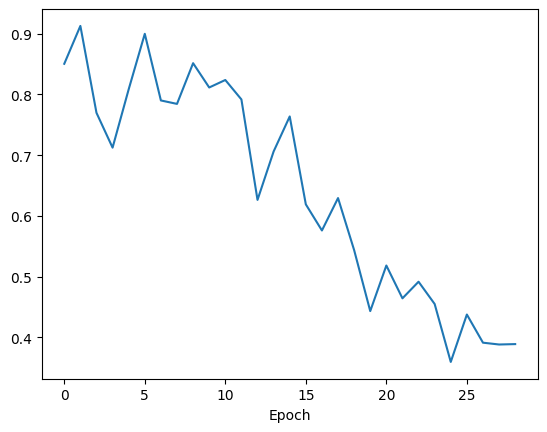

In [172]:
x_label = list(range(len(loss_list)))
plt.plot(x_label, acc_list)
plt.xlabel("Epoch")
plt.show()

In [173]:
print("\n=== Forward T (clean→noisy) ===")
print(np.array_str(Tf, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tf.sum(axis=1), 3))

print("\n=== Backward T (noisy→clean) ===")
print(np.array_str(Tb, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tb.sum(axis=1), 3))


=== Forward T (clean→noisy) ===
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]
row sums: [1. 1. 1.]

=== Backward T (noisy→clean) ===
[[1.371 0.001 0.001]
 [0.    1.369 0.001]
 [0.    0.    1.372]]
row sums: [1.373 1.37  1.373]
